In [117]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import yscale
from scipy import signal
from typing import Union, Sequence

# Am Anfang wird immer in Bursts übertragen, ohne Kontinuierliches Senden

# IQ Sampling

Ziel dieses Notebooks ist es, ein Verständnis für die generierung und Abtastung von IQ-Samples zu entwickeln. Dabei soll Rauschen und der Einfluss des Kanals zunächst vernachlässigt werden. Der Fokus soll hier allein auf dem Verständnis liegen, wie IQ Samples von einem SDR versendet werden, als reales Signal übertragen werden und wie sie empfangen werden.

Am Ende des Notebooks sollte folgendes klar sein:

- Was sind IQ-Samples?
- Das Sendesignal wird immer komplex beschrieben. Übertragen wird jedoch nur der Realteil. Warum?
- Wie werden aus dem realen, analogen Empfangssignal die komplexen IQ-Samples gewonnen?
- Warum können der I- und Q-Teil überlagert ausgesendet werden und dennoch beim Empfänger getrennt werden?

# Theoretischer Background: TX und RX

## Transmitter

Der Transmitter (TX) erzeugt ein diskretes komplexes Basisband-Signal $s_{\text{NF}}[n]$, welches in der Regel als I/Q-Signal bezeichnet wird. Das I/Q-Signal besteht aus zwei Komponenten: der In-Phase-Komponente (I) und der Quadratur-Komponente (Q). Das I/Q-Signal $s_{\text{NF}}[n]$ wird dann auf eine Trägerfrequenz $f_{\text{c}}$ hochgemischt und als analoges Passband Signal $s_{\text{HF}}(t)$ übertragen.



$$s_{\text{NF}}[n] = I[n] + j \text{ } Q[n]$$

* $I[n]$ ist die In-Phase-Komponente (Kosinus Anteil, Realteil)
* $Q[n]$ ist die Quadratur-Komponente (Sinus Anteil, Imaginärteil)
* Bsp.: QPSK-Sample
$$
\begin{align*}
s_{\text{QPSK}} &= 1 + j \\
                &= \sqrt{2} \text{ } e^{j\frac{\pi}{4}} \\
                &=  \sqrt{2} \cos(\frac{\pi}{4}) + j \sqrt{2}  \sin(\frac{\pi}{4}) \\
                &= I + j Q
                &= \sqrt{2} \left(\frac{\sqrt{2}}{2} + j \frac{\sqrt{2}}{2}\right) \\
                &= 1 + j
\end{align*}
$$

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

Werden die IQ-Samples vom ausgesendet, werden sie als reales Signal übertragen.

### Im SDR wird das wie im Blockschaltbild folgendermaßen realisiert:
- Es wird ein $\cos{2 \pi f_c t}$ generiert, mit Trägerfrequenz $f_{\text{c}}$ generiert
- Dieser wird dann zum einen mit der realen Komponente (I-Komponente) multipliziert
- Für die imaginäre Komponente (Q-Komponente) wird auf den Cosinus eine Phasenverschiebung von $\frac{\pi}{2}$ angewendet: $\cos{(2 \pi f_c t + \frac{\pi}{2})} = - \sin(2 \pi f_c t)$
- Dieser wird dann zum einen mit der realen Komponente (Q-Komponente) multipliziert
- Durch das Superpositionsprinzip addieren sich beide Komponenten zu:
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t)
$$

#### Bemerkung Orthogonalität:
Die beiden Signale sind orthogonal zueinander, d.h. das Skalarprodukt ist 0. Das bedeutet, dass die beiden Signale unabhängig voneinander sind und der Empfänger die I und Q Komponenten aus der Summe extrahieren kann.

In [118]:
def generate_m_sequence(length=16):
    """
    Generiert eine 16 Bit lange M-Sequenz mit LFSR (Linear Feedback Shift Register) als BPSK Sequenz.
    Verwendetes primitives Polynom: x^4 + x^3 + 1 (Taps an Position 3 und 4)
    """
    register = [1, 1, 1, 1]  # Initialzustand (darf nicht alle 0 sein)
    sequence = []

    for _ in range(length):
        # Feedback-Berechnung (XOR der Taps)
        feedback = register[3] ^ register[2]  # 0-indizierte Positionen
        sequence.append(register.pop())
        register.insert(0, feedback)

    return 2*np.asarray(sequence)-1

def zadoff_chu_sequence(length, root=25):
    """
    Generiert zu gegebener Länge und Wurzel eine ZC-Sequenz (QPSK).
    :param length:
    :param root:
    :return:
    """
    n = np.arange(0, length)
    if length % 2 != 0:
        return np.exp(1j * np.pi * root * n * (n + 1) / length)
    return np.exp(1j * np.pi * root * n**2 / length)


def normalize_energy(signal):
    energy = np.sum(np.abs(signal) ** 2)
    return signal / np.sqrt(energy)

import numpy as np

def create_dirac_impulse(t, tau, amplitude=1.0, width=1e-9):
    """
    Erzeugt eine Annäherung an einen Dirac-Impuls.

    :param t: Zeitvektor (numpy array)
    :param tau: Verschiebung des Impulses in Sekunden
    :param amplitude: Amplitude des Impulses (Standard: 1.0)
    :param width: Breite des Impulses in Sekunden (Standard: 1e-9)
    :return: numpy array mit dem Dirac-Impuls
    """
    # Berechne die Zeitauflösung
    dt = t[1] - t[0]

    # Initialisiere das Ausgabe-Array mit Nullen
    dirac = np.zeros_like(t)

    # Finde den Index, der tau am nächsten ist
    idx = np.argmin(np.abs(t - tau))

    # Setze den Impuls
    if width <= dt:
        # Wenn die gewünschte Breite kleiner als die Zeitauflösung ist,
        # setze einfach einen einzelnen Punkt
        dirac[idx] = 1
    else:
        # Andernfalls erstelle einen schmalen Rechteckimpuls
        half_width = int(width / (2 * dt))
        start = max(0, idx - half_width)
        end = min(len(t), idx + half_width + 1)
        dirac[start:end] = 1

    return dirac



## Generierung des Sendesignals

Das Sendesignal wird aus den Datenbits und einer Synchronisationssequenz generiert. Die Synchronisationssequenz wird verwendet, um den Empfänger zu synchronisieren. Das Sendesignal wird dann mit einem Raised-Cosine Filter gepulst, um die Bandbreite des Signals zu begrenzen.

### Konvertierung der Datenbits $\vec{b}[i]$ in BPSK Samples

   $$
    \text{BPSK}(i) = \vec{b}[i] \cdot 2 - 1
   $$

Es sollen T = 8 Samples pro Symbol verwendet werden. Das Sendesignal wird dann wie folgt generiert:

$$
    x_{\text{NF, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i T\right)
$$

Für IQ-Modulation wird das für den I und Q Teil getrennt durchgeführt, somit ergibt sich:

$$
    x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}
$$
$$
    x_{\text{Q, no shape}}[n] = \Im\left\{x_{\text{NF, no shape}}[n]\right\}
$$

## Generierung der Bits $\vec{b}[i]$

#### Aufgabe:
- Erstellen Sie ein beliebige Datenbits in `data_bits`

In [119]:
data_bits = np.array([0,0,1,1,1])

### Mapping der Bits $\vec{b}[i]$ auf Modulationssymbole

- Ziel: NumPy Array mit den Modulationssymbolen
- $\vec{b}[i]$ wird auf ein Modulationssymbole $d(i)$ gemappt
- Wählen Sie, welche Modulation Sie verwenden wollen (BPSK, QPSK, ...)
- Anweisung: Überlegen Sie sich, wie Sie die Bits auf die Modulationssymbole der gewählten Modulation mappen

#### Aufgabe:
- Erstellen Sie ein Array `modulation_data_symbols`, welches die gemappten bits $\vec{b}[i]$ enthält

In [120]:
modulation_data_symbols = 2 * data_bits - 1 # Lösung für BPSK
modulation_data_symbols

array([-1, -1,  1,  1,  1])

#### Aufgabe:
- Erstellen eine Synchronisationssequenz in `synchronization_sequence`
- Hinweis: Sie können auch die obige Funktion `generate_m_sequence()` oder `zadoff_chu_sequence()` verwenden

In [121]:
synchronization_sequence = zadoff_chu_sequence(31, root=25)
#synchronization_sequence = generate_m_sequence()

#### Aufgabe:
- Ziel: Symbole der Synchronisationssequenz & Datensymbole in einem Array von Modulationssymbolen $d(i)$
- Konkatenieren Sie die `synchronization_sequence` mit den Daten Symbolen `modulation_data_symbols`
- Die Konkatenation führt zu einem Array der modulierten Basisbandsymbole $d(i)$ in `symbols`

In [122]:
symbols = np.concatenate((synchronization_sequence, modulation_data_symbols))

### Design Basisbandpulse $h_{\text{Pulse Form}}[n]$

In [123]:
def get_raised_cosine_pulse(num_taps=101, roll_off=0.35, samples_per_symbol=8):
    Ts = samples_per_symbol
    t = np.arange(num_taps) - (num_taps-1)//2
    h = np.sinc(t/Ts) * np.cos(np.pi*roll_off*t/Ts) / (1 - (2*roll_off*t/Ts)**2)
    return h

def get_rect_pulse(num_taps=101, samples_per_symbol=8):
    h = np.zeros(num_taps)
    h[num_taps//2-samples_per_symbol//2:num_taps//2+samples_per_symbol//2] = 1
    return h

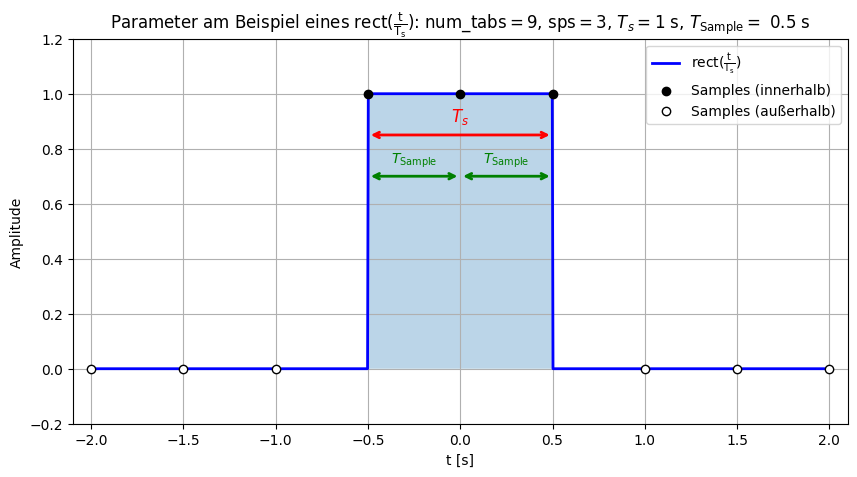

In [124]:
T_s = 1  # Symboldauer (von -0.5 bis 0.5)
num_samples = 3  # Anzahl der Samples innerhalb des Pulses
T_sample = T_s / (num_samples - 1)  # Abstand zwischen den Samples

T = np.linspace(-2, 2, 1000)
pulse = np.where((T >= -T_s / 2) & (T <= T_s / 2), 1, 0)

samples_x = np.linspace(-T_s / 2, T_s / 2, num_samples)
samples_y = [1] * num_samples

offset_samples_x = np.array([-2, -1.5, -1, 1, 1.5, 2])
offset_samples_y = [0] * len(offset_samples_x)

plt.figure(figsize=(10, 5))

plt.plot(T, pulse, label=r'$\rm{rect}(\frac{t}{T_s})$', color='blue', linewidth=2)
plt.fill_between(T, pulse, alpha=0.3)

plt.scatter(samples_x, samples_y, color='black', label='Samples (innerhalb)', zorder=5)

plt.scatter(offset_samples_x, offset_samples_y, color='white', edgecolor='black', label='Samples (außerhalb)', zorder=5)

plt.annotate("", xy=(-T_s / 2, 0.85), xytext=(T_s / 2, 0.85), arrowprops=dict(arrowstyle='<->', color='red', lw=2))
plt.text(0, 0.9, r'$T_s$', color='red', fontsize=12, ha='center')

for i in range(num_samples - 1):
    plt.annotate("", xy=(samples_x[i], 0.7), xytext=(samples_x[i + 1], 0.7),
                 arrowprops=dict(arrowstyle='<->', color='green', lw=2))
    plt.text((samples_x[i] + samples_x[i + 1]) / 2, 0.75, r'$T_{\rm{Sample}}$', color='green', fontsize=10, ha='center')

plt.title(r'Parameter am Beispiel eines $\rm{rect}(\frac{t}{T_s})$: num_tabs$=$'+f'{int(samples_x.size + offset_samples_x.size)}' + r", sps$=$" + f"{samples_x.size}" + r", $T_s = $"+ f"{T_s} s," + r" $T_{\rm{Sample}} = $ " + f"{T_sample} s")
plt.xlabel('t [s]')
plt.ylabel('Amplitude')
plt.ylim(-0.2, 1.2)
plt.xlim(-2.1, 2.1)
plt.grid()
plt.legend()

plt.show()

#### Aufgabe:
- Machen Sie sich mit den nachfolgenden Parametern vertraut, diese werden nachfolgend immer wieder verwendet und spielen eine wichtige Rolle für die korrekte Auflösung der Signale
- Befolgen Sie die Anweisungen in den Kommentaren (Sie können die Parameter auch selbst sinnvoll frei wählen).

In [125]:
# Basisband Puls soll eine Dauer T_s von 0.5 Sekunden haben
T_s = 1/2 # in seconds

# Der Puls soll 16 samples lang sein
sps = 16

# Dauer eines Samples entspricht T_s / sps
T_sample = T_s / sps

# num_tabs gibt die Gesamtlänge des Basisband Pulses an, muss natürlich länger sein als die Länge des Pulses sps. sps=101 wäre eine gute Zahl.
num_taps = 101

#### Aufgabe: Zeitsignal des Basisband Pulses
- Erstellen Sie einen Basisband Puls $h_{\text{Pulse Form}}[n]$
- Verwenden Sie dazu eine der oben bereits definierten Funktionen:
    - `get_rect_pulse`
    - `get_raised_cosine_pulse`
- Empfehlung: Beginnen Sie mit einem  $h_{\text{Pulse Form}}[n] = \text{rect}[n]$, so können Sie später die Unterschiede bei Verwendung eines *Raised Cosine Pulses* besser erkennen.

#### Aufgabe: Spektrum des Basisbandimpulses $\mathfrak{F} \{ h_{\text{Pulse Form}}[n] \}$
- Hinweis: Den Frequenzvektor $f$ erhalten Sie durch die Funktion `np.fft.fftfreq(signal.length, time_between_samples)`
- NumPy bringt die Nullfrequenz an den Anfang, daher sollten Sie die Funktion `np.fft.fftshift` verwenden, um die Nullfrequenz in die Mitte zu schieben
- Denken Sie daran, das gleiche auch für den Frequenzvektor $f$ zu tun

##### Anweisungen
- Berechnen Sie $\mathfrak{F} \{ h_{\text{Pulse Form}}[n] \}$ für `baseband_spectrum`
- Erstellen Sie in passender Auflösung dazu den Frequenzvektor `f`

In [126]:
# time
h_pulse_form = get_rect_pulse(num_taps=num_taps, samples_per_symbol=sps)
t = np.arange(len(h_pulse_form)) * T_sample - len(h_pulse_form)//2 * T_sample

# frequency
baseband_spectrum = np.fft.fftshift(np.fft.fft(h_pulse_form))
f = np.fft.fftshift(np.fft.fftfreq(len(h_pulse_form), T_sample))

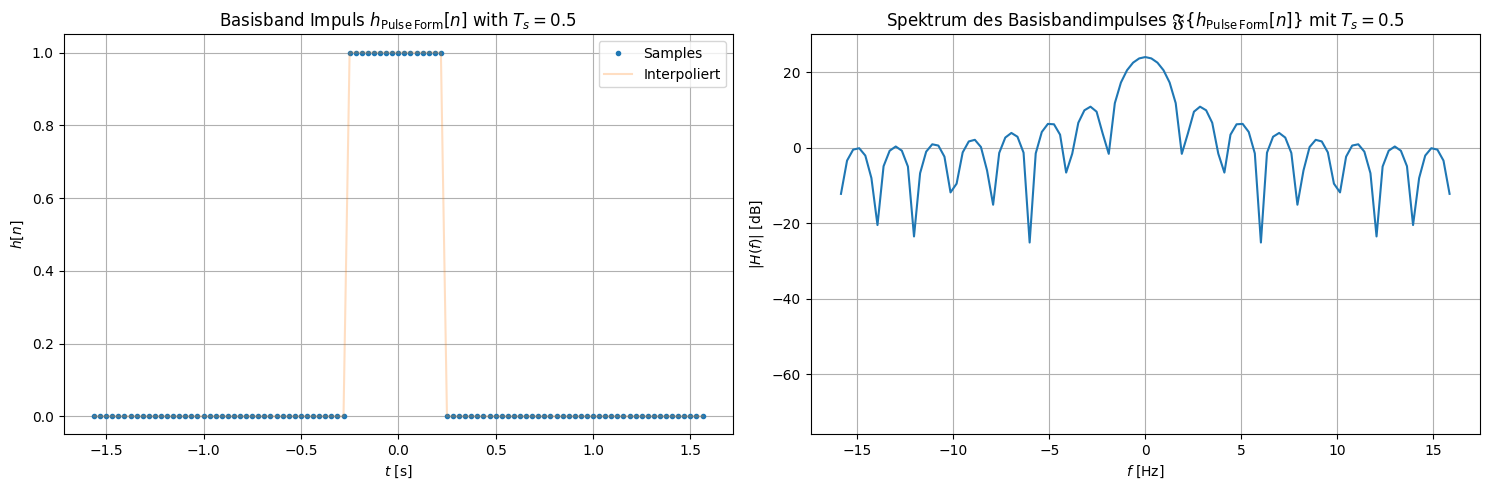

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot time-domain representation
ax1.plot(t, h_pulse_form, '.')
ax1.plot(t, h_pulse_form, '-', alpha=0.25)
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'$h[n]$')
ax1.set_title(r"Basisband Impuls $h_{\mathrm{Pulse\,Form}}[n]$ with $T_s = $" + f"{T_s}")
ax1.grid(True)
ax1.legend(["Samples", "Interpoliert"])

# Plot frequency-domain representation
ax2.plot(f, 10*np.log10(np.abs(baseband_spectrum)**2))
ax2.set_title(r"Spektrum des Basisbandimpulses $\mathfrak{F} \{ h_{\mathrm{Pulse\,Form}}[n] \}$ mit $T_s = $" + f"{T_s}")
ax2.set_xlabel(r'$f$ [Hz]')
ax2.set_ylabel(r'$|H(f)|$ [dB]')
ax2.grid(True)
max_value = np.max(10*np.log10(np.abs(baseband_spectrum)**2))
ax2.set_ylim(max_value-100, 1.25*max_value)

plt.tight_layout()
plt.show()

### Bilden Sie die Dirac-Summe der Modulationssymbole $x_{\text{no shape}}[n] = \sum_{i=0}^{N-1} d(i) \text{ } \delta\left(t - i T_s\right) $

- Ziel: NumPy Array mit der Dirac-Summe $x_{\text{no shape}}[n]$.
1. Eine Dirac-Summe $x_{\text{I,no shape}}[n]$ für den I-Anteil, welche die Realteile der Symbole $ \Re \{d(i)\} $ enthält
2. Eine Dirac-Summe $x_{\text{I,no shape}}[n]$ für den Q-Anteil, welche die Imaginärteile der Symbole $ \Im \{d(i)\} $ enthält
- Hinweis: Die Zeit $t$ ist diskret, wobei ein Indexbin $n$ einem Zeitpunkt $t = n \cdot T_{\text{Sample}}$ entspricht
    - Die Dauer eines Samples $T_{\text{sample}}$ ist gegeben durch: $T_{\text{sample}} = \frac{T_s}{\text{sps}}$
- Das bedeutet die einzelnen Dirac-Summanden brauchen einen zeitlichen Abstand von $T_{\text{s}}$,
was in Samples durch die Beziehung $T_{Sample} $  [ $ \frac{s}{Sample} $] $ =  \frac{T_s}{sps} \text{ } $[ $ \frac{s}{Sample} $] gegeben ist. Durch Umstellen ergibt sich der Abstand in Samples durch:

$$ \text{sps} = \frac{T_s}{T_{\text{Sample}}} \quad \text{, die Einheit beider Seiten ist nun Samples}$$

In Bins ausgedrückt ergeben sich die Dirac-Summen $x_{\text{I,no shape}}[n]$ & $x_{\text{Q,no shape}}[n]$ zu:

$$
    x_{\text{I, no shape}}[n] = \sum_{i=0}^{N-1} \Re \{d(i)\} \text{ } \delta\left(n - i \text{ sps}\right) \quad \text{, mit } N = \text{len(d(i))}\cdot sps
$$
$$
    x_{\text{Q, no shape}}[n] = \sum_{i=0}^{N-1} \Im \{d(i)\}  \text{ } \delta\left(n - i \text{ sps}\right) \quad \text{, mit } N = \text{len(d(i))}\cdot sps
$$

#### Aufgabe:
- Erstellen Sie die Dirac-Summe $x_{\text{I, no shape}}[n]$ in `x_i_no_shape`
- Erstellen Sie die Dirac-Summe $x_{\text{Q, no shape}}[n]$ in `x_q_no_shape`
- Erstellen Sie zusätzlich die Zeitvariable `t`
- Hinweis: Der `signal.gausspulse` der Scipy Bibliothek kann für $\delta (t)$ verwendet werden


In [128]:
x_i_no_shape = np.zeros(len(symbols) * sps)
x_q_no_shape = np.zeros(len(symbols) * sps)

t = np.arange(len(x_i_no_shape)) * T_sample
for n in range(len(symbols)):
    x_i_no_shape += symbols[n].real * create_dirac_impulse(t, n*T_s)
    x_q_no_shape += symbols[n].imag * create_dirac_impulse(t, n*T_s)

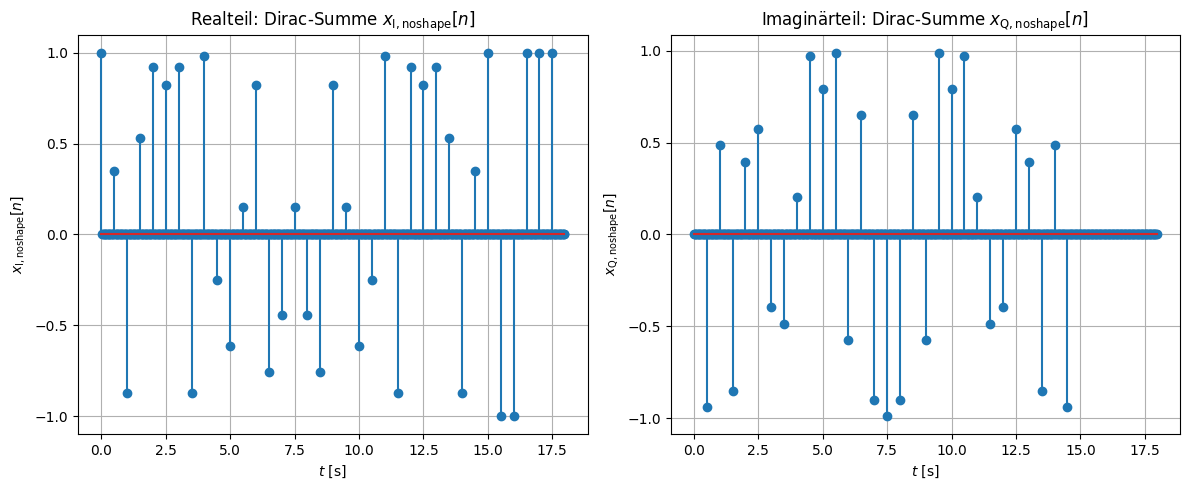

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.stem(t, x_i_no_shape)
ax1.grid(True)
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'$x_{\rm{I, no shape}}[n]$')
ax1.set_yticks([-1, -0.5, 0, 0.5, 1])
ax1.set_title(r"Realteil: Dirac-Summe $x_{\rm{I, no shape}}[n]$")

ax2.stem(t, x_q_no_shape)
ax2.grid(True)
ax2.set_xlabel(r'$t$ [s]')
ax2.set_ylabel(r'$x_{\rm{Q, no shape}}[n]$')
ax2.set_yticks([-1, -0.5, 0, 0.5, 1])
ax2.set_title(r"Imaginärteil: Dirac-Summe $x_{\rm{Q, no shape}}[n]$")

plt.tight_layout()
plt.show()

## Pulsformung

Um das Basisbandsignal $x_{\text{I, shaped}}[n] $ & $x_{\text{Q, shaped}}[n]$ müssen die Diracsummen $x_{\text{I, no shape}}[n]$ & $x_{\text{Q, no shape}}[n]$ mit einem Basisband Puls $h_{\tiny{\text{Pulse Form}}}[n]$ geformt werden. Dies wird durch eine Faltung wie folgt erreicht:

$$
    x_{\text{I, shaped}}[n] = x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$
$$
    x_{\text{Q, shaped}}[n] = x_{\text{Q, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$

#### Aufgabe:

- Berechnung von $x_{\text{I, shaped}}[n]$ in `x_i_shaped`
- Berechnung von $x_{\text{Q, shaped}}[n]$ in `x_q_shaped`
- Erstellen Sie ein passenden Zeitvektor `t`
- Berechnen Sie $\mathfrak{F} \{x_{\text{I, shaped}}[n] \}$ und speichern Sie das Ergebnis in `x_i_shaped_spectrum`
- Berechnen Sie $\mathfrak{F} \{x_{\text{Q, shaped}}[n] \}$ und speichern Sie das Ergebnis in `x_q_shaped_spectrum`
- Erstellen Sie in der korrekten Auflösung den zugehörigen Frequenzvektor `f`
- Hinweise:
    - Nutzen Sie die Funktion `np.convolve` für die Faltung
    - Der Basisbandpuls $h_{\tiny{\text{Pulse Form}}}[n]$ ist bereits gegeben: `h_pulse_form`

In [130]:
x_i_shaped = np.convolve(x_i_no_shape, h_pulse_form)
x_q_shaped = np.convolve(x_q_no_shape, h_pulse_form)
t = np.arange(x_i_shaped.size) * T_sample

x_i_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_i_shaped))
x_q_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_q_shaped))
f = np.fft.fftshift(np.fft.fftfreq(x_i_shaped.size, T_sample))

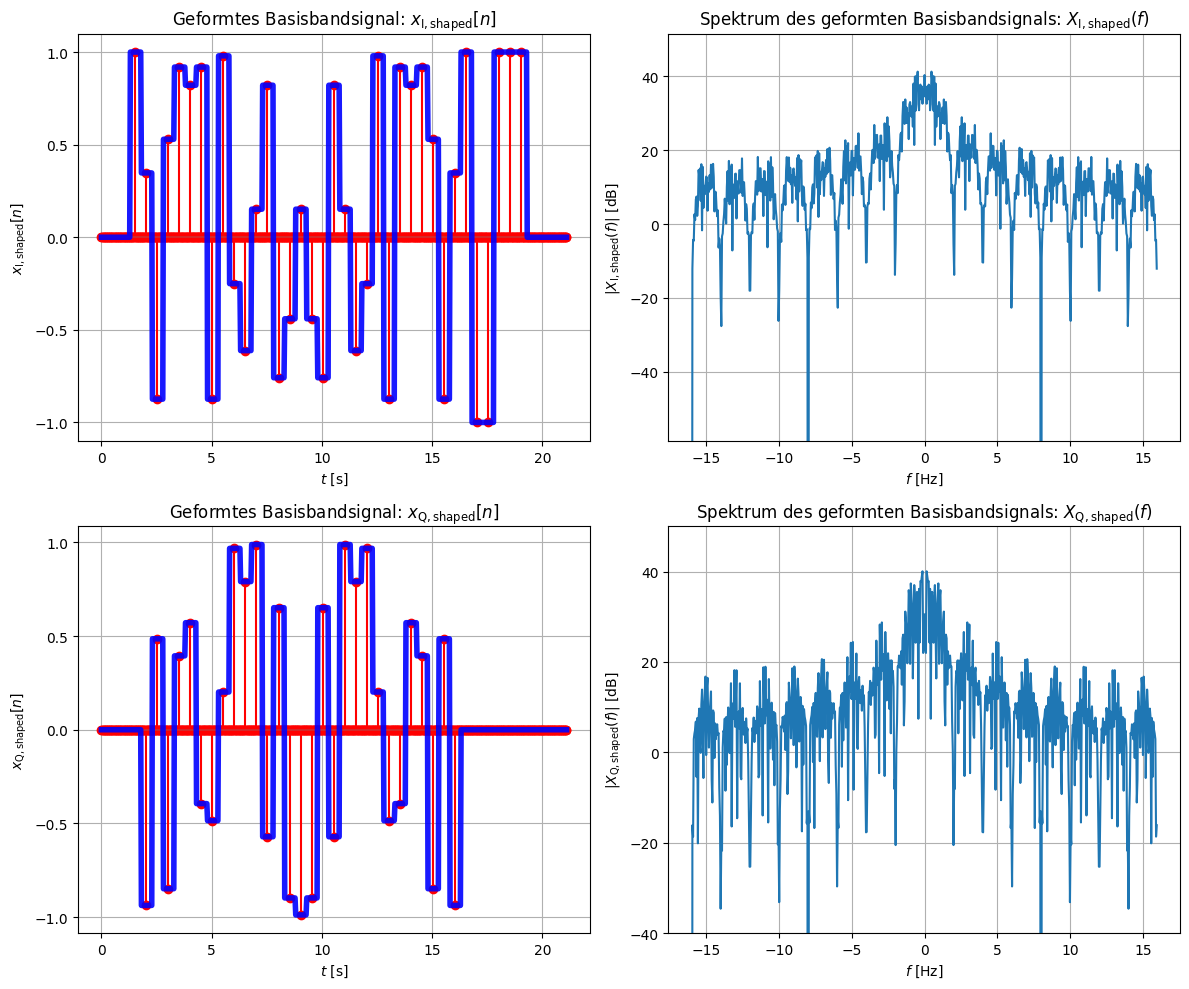

In [131]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

dirac_sum_zero_padded = np.zeros(len(x_i_shaped))
dirac_sum_zero_padded[h_pulse_form.size//2-1:h_pulse_form.size//2+len(x_i_no_shape)-1] = x_i_no_shape
ax1.stem(t, dirac_sum_zero_padded, 'r')
ax1.plot(t, x_i_shaped, 'b', linewidth=4, alpha=0.9)
ax1.set_yticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(True)
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'$x_{\rm{I, shaped}}[n]$')
ax1.set_title(r"Geformtes Basisbandsignal: $x_{\rm{I, shaped}}[n]$")

ax2.plot(f, 10*np.log10(np.abs(x_i_shaped_spectrum)**2))
ax2.set_xlabel(r"$f$ [Hz]")
ax2.set_ylabel(r"$|X_{\rm{I, shaped}}(f)|$ [dB]")
ax2.set_title(r"Spektrum des geformten Basisbandsignals: $X_{\rm{I, shaped}}(f)$")
ax2.grid(True)
max_value = np.max(10*np.log10(np.abs(x_i_shaped_spectrum)**2))
ax2.set_ylim([max_value-100, max_value*1.25])

dirac_sum_zero_padded = np.zeros(len(x_q_shaped))
dirac_sum_zero_padded[h_pulse_form.size//2-1:h_pulse_form.size//2+len(x_q_no_shape)-1] = x_q_no_shape
ax3.stem(t, dirac_sum_zero_padded, 'r')
ax3.plot(t, x_q_shaped, 'b', linewidth=4, alpha=0.9)
ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
ax3.grid(True)
ax3.set_xlabel(r'$t$ [s]')
ax3.set_ylabel(r'$x_{\rm{Q, shaped}}[n]$')
ax3.set_title(r"Geformtes Basisbandsignal: $x_{\rm{Q, shaped}}[n]$")

tmp = x_q_shaped_spectrum + 1e-100 if np.all(x_q_shaped_spectrum == 0) else x_q_shaped_spectrum
ax4.plot(f, 10*np.log10(np.abs(tmp)**2))
ax4.set_xlabel(r"$f$ [Hz]")
ax4.set_ylabel(r"$|X_{\rm{Q, shaped}}(f)|$ [dB]")
ax4.set_title(r"Spektrum des geformten Basisbandsignals: $X_{\rm{Q, shaped}}(f)$")
ax4.grid(True)
max_value = np.max(10*np.log10(np.abs(tmp)**2))
if max_value > 0:
    ax4.set_ylim([-max_value, max_value*1.25])
else:
    ax4.set_ylim([max_value-100, 5])


plt.tight_layout()
plt.show()

### Aufbau des Trägersignals

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

- Gemäß des Blockschaltbildes brauchen wir ein Carrier $s_c(t)$, welcher das Basisbandsignal auf eine Trägerfrequenz $f_c$ hochmischen kann
- Dieser wird direkt mit dem I-Anteil des Basisbandsignals $x_{\text{I, shaped}}(t)$ multipliziert
- Der I-Anteil wird laut obigen Berechnungen mit dem Cosinus übertragen. Blockschaltbild konform muss $s_c(t)$ für den I-Anteil also wie folgt aussehen:
$$
    s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Aus der $90°$ Phasendrehung folgt, dass $s_c(t)$ für den Q-Anteil wie folgt aussehen muss:
$$
    s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = - \sin(2 \pi f_c t)
$$

#### Aufgabe:
- Generieren Sie zu $f_c = 2$ die Träger $s_{\text{c,I}}(t)$ in `s_c_I` und $s_{\text{c,Q}}(t)$ in `s_c_Q`
- Erstellen Sie einen passenden Zeitvektor `t`

In [132]:
t = np.arange(x_i_shaped.size) * T_sample
f_c = 2

s_c_I = np.cos(2*np.pi*f_c*t)
s_c_Q = np.cos(2*np.pi*f_c*t + np.pi/2)

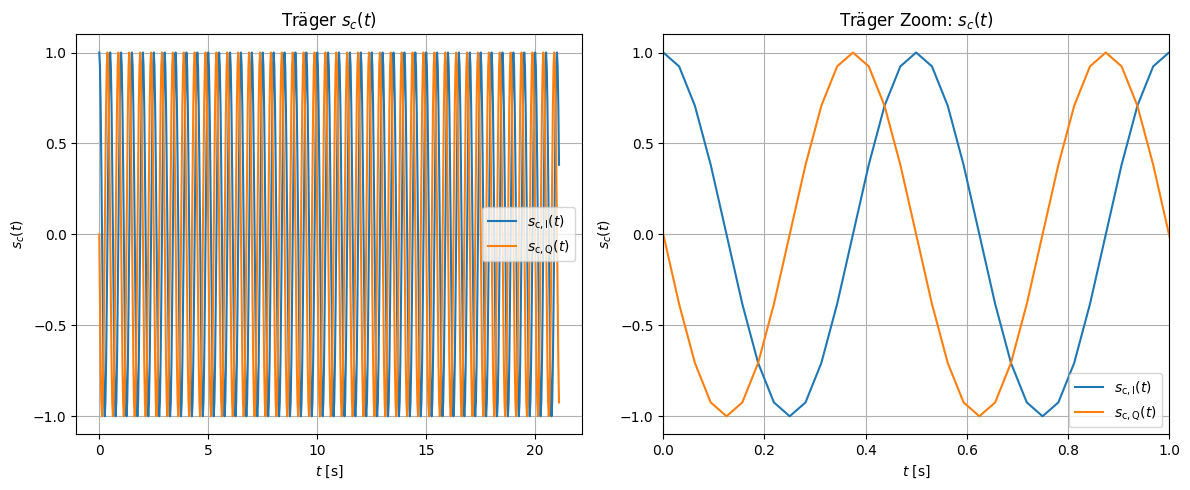

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the full carrier signals
ax1.plot(t, s_c_I)
ax1.plot(t, s_c_Q)
ax1.set_title(r"Träger $s_c(t)$")
ax1.set_xlabel(r"$t$ [s]")
ax1.set_ylabel(r"$s_c(t)$")
ax1.legend([r"$s_{\rm{c,I}}(t) $", r"$s_{\rm{c,Q}}(t) $"])
ax1.set_yticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(True)

# Plot a zoomed-in view of two periods
period = 1 / f_c
zoom_start = 0
zoom_end = 2 * period
ax2.plot(t, s_c_I)
ax2.plot(t, s_c_Q)
ax2.set_xlim([zoom_start, zoom_end])
ax2.set_title(r"Träger Zoom: $s_c(t)$")
ax2.set_xlabel(r"$t$ [s]")
ax2.set_ylabel(r"$s_c(t)$")
ax2.legend([r"$s_{\rm{c,I}}(t) $", r"$s_{\rm{c,Q}}(t) $"])
ax2.set_yticks([-1, -0.5, 0, 0.5, 1])
ax2.grid(True)

plt.tight_layout()
plt.show()

### Hoschmischen des Basisbandsignals $x_{\text{I, shaped}}(t)$ & $x_{\text{Q, shaped}}(t)$auf die Trägerfrequenz $f_c$

Wie bereits erwähnt, kann das Passbandsignal $s_{\text{HF}}(t)$ kann also wie folgt beschrieben werden:
$$
\begin{align*}
    s_{\text{HF}}(t) &= I(t) s_{\text{c,I}}(t) + Q(t) s_{\text{c,Q}}(t) \\
    &= I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t) \\
\end{align*}
$$
Wobei:
- $I(t) = x_{\text{I, shaped}}(t)$
- $Q(t) = x_{\text{Q, shaped}}(t)$

#### Aufgabe:
- Berechnen Sie $s_{\text{HF}}(t)$ in `s_hf`
- Erstellen Sie den passenden Zeitvektor `t`

In [134]:
s_hf = x_i_shaped * s_c_I + x_q_shaped * s_c_Q
t = np.arange(s_hf.size) * T_sample

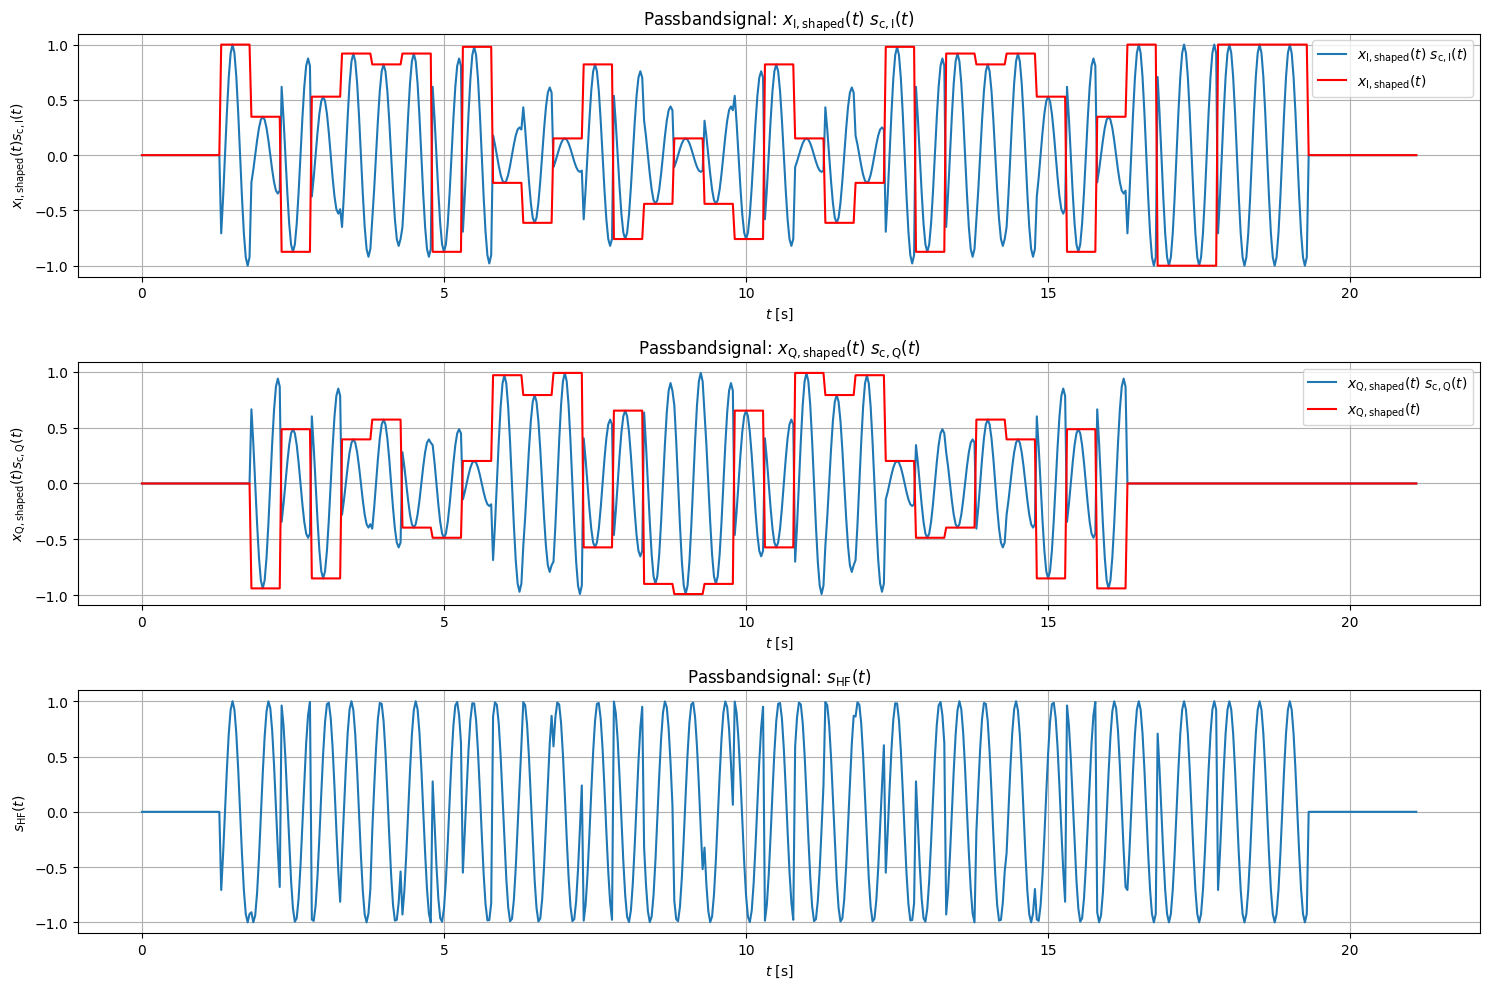

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

# Plot I(t) * s_c,I(t)
ax1.plot(t, x_i_shaped * s_c_I, label=r"$x_{\rm{I, shaped}}(t) $ $ s_{\rm{c,I}}(t)$")
ax1.plot(t, x_i_shaped, color='red', label=r"$x_{\rm{I, shaped}}(t) $")
ax1.set_title(r"Passbandsignal: $x_{\rm{I, shaped}}(t) $ $ s_{\rm{c,I}}(t)$")
ax1.set_ylabel(r"$x_{\rm{I, shaped}}(t) s_{\rm{c,I}}(t)$")
ax1.set_xlabel(r"$t$ [s]")
ax1.legend()
ax1.grid(True)

# Plot Q(t) * s_c,Q(t)
ax2.plot(t, x_q_shaped * s_c_I, label=r"$x_{\rm{Q, shaped}}(t) $ $ s_{\rm{c,Q}}(t)$")
ax2.plot(t, x_q_shaped, color='red', label=r"$x_{\rm{Q, shaped}}(t) $")
ax2.set_title(r"Passbandsignal: $x_{\rm{Q, shaped}}(t) $ $ s_{\rm{c,Q}}(t)$")
ax2.set_ylabel(r"$x_{\rm{Q, shaped}}(t) s_{\rm{c,Q}}(t)$")
ax2.set_xlabel(r"$t$ [s]")
ax2.legend()
ax2.grid(True)

# Plot s_HF(t)
ax3.plot(t, s_hf)
ax3.set_title(r"Passbandsignal: $s_{\rm{HF}}(t)$")
ax3.set_ylabel(r"$s_{\rm{HF}}(t)$")
ax3.set_xlabel(r"$t$ [s]")
ax3.grid(True)

plt.tight_layout()
plt.show()

#### Spektrum des Passbandsignals $\mathfrak{F} \{ s_{\tiny{\text{HF}}}(t) \}$

#### Aufgabe:
- Berechnen Sie $\mathfrak{F} \{ s_{\tiny{\text{HF}}}(t) \}$ in `s_hf_spectrum`
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`

In [136]:
s_hf_spectrum = np.fft.fftshift(np.fft.fft(s_hf))
f = np.fft.fftshift(np.fft.fftfreq(s_hf.size, T_sample))

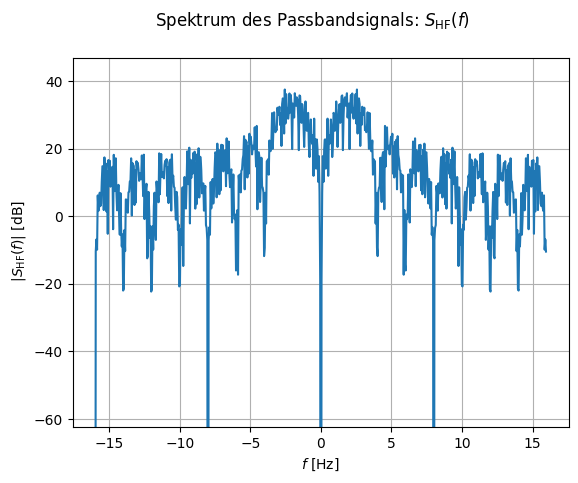

In [137]:
plt.suptitle(r"Spektrum des Passbandsignals: $S_{\rm{HF}}(f)$")
plt.plot(f, 10*np.log10(np.abs(s_hf_spectrum)**2))
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r" $ | S_{\rm{HF}}(f) | $ [dB]")
plt.grid(True)
max_val = np.max(10*np.log10(np.abs(s_hf_spectrum)**2))
plt.ylim(max_val-100, 1.25*max_val)
plt.show()

## Empfänger (Direct Downconversion)

Bei der _Direct Downconversion_, wird vom Empfangssignal im SDR der I und Q Teil separat extrahiert. So kann das reale Empfangssignal wieder in die komplexe Basisbandsignalform zurückgeführt werden.

<div style="text-align: center;">
    <img src="./images/IQ_sampling_receiver.png" alt="IQ Sampling Receiver" width="400"/>
</div>

- Gemäß Blockschaltbild wird ein Trägersignal $s_{\text{c}}(t)$ benötigt. Dieses muss die gleiche Trägerfrequenz $f_c$ haben wie auch der Träger beim Sender
    - Für den I-Anteil wird wie beim Sender $s_{\text{c,I}}(t) = \cos(2 \pi f_c t)$ verwendet (oberer Teil im Blockschaltbild)
    - Für den Q-Anteil wird eine Phasendrehung von $\Phi = \frac{\pi}{2}$ auf $ s_{\text{c,I}}(t) $ angewendet: $s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = \sin(2 \pi f_c t)$
- Wichtig: Die Schritte Heruntermischen und Filtern finden bis zur ADC kontinuierlich statt
- Bei der ADC wird das Signal mit der Sampling Rate $f_s$ *diskretisiert* und die reellen Samples *quantisiert*




## Extraktion des I-Anteils (oberer Teil im Blockschaltbild):

Das Heruntermischen von $ s_{\text{HF}}(t) $ mit dem Träger für den I-Anteil $s_{\text{c,I}}(t)$ lässt sich wie folgt beschreiben:

\begin{align*}
    \hat{I}_{\text{No Filter}}(t) &= s_{\text{HF}}(t) s_{\text{c,I}}(t) \\
    &= s_{\text{HF}}(t) \cos(2\pi f_{\text{c}} t) \\
    &= \frac{1}{2} I(t) \cos(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \sin(4\pi f_{\text{c}} t) + \frac{1}{2} I(t)
\end{align*}
Ziel: Hochfrequente Anteile entfernen, sodass $\frac{1}{2} I(t)$ übrig bleibt.

Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter $h_{\tiny{\text{TP}}}(t)$ eliminiert:

\begin{align*}
    \hat{I}_{\text{Filtered}}(t) &= \hat{I}_{\text{No Filter}}(t) * h_{\tiny{\text{TP}}}(t) \\
    &= \mathfrak{F^{-1}} \{ \hat{I}_{\text{No Filter}}(f) \cdot H_{\tiny{\text{TP}}}(f) \} \\
    &\approx x_{\text{I, shaped}}(t) \approx x_{\text{I, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t)
\end{align*}

Der I-Anteil des Basisbandsignals $\hat{I}[n]$ wird dann durch eine ADC (Diskretisierung & Quantisierung) des Signals gewonnen:
\begin{align*}
    \hat{I}_{\text{Filtered}}(t) &\approx x_{\text{I, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t) \\
    \hat{I}[n] &= x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n] \text{, } \quad t= \frac{n}{f_s}
\end{align*}

## Extraktion des Q-Anteils (unterer Teil im Blockschaltbild):
\begin{align*}
    \hat{Q}_{\text{No Filter}}(t) &= s_{\text{HF}}(t) s_{\text{c,Q}}(t) \\
    &= - s_{\text{HF}}(t) \sin(2\pi f_{\text{c}} t) \\
    &= - \frac{1}{2} I(t) \sin(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t)
\end{align*}

Ziel: Hochfrequente Anteile entfernen, sodass $\frac{1}{2} Q(t)$ übrig bleibt.

Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter $h_{\tiny{\text{TP}}}(t)$ eliminiert:

\begin{align*}
    \hat{Q}_{\text{Filtered}}(t) &= \hat{Q}_{\text{No Filter}}(t) * h_{\tiny{\text{TP}}}(t) \\
    &= \mathfrak{F^{-1}} \{ \hat{Q}_{\text{No Filter}}(f) \cdot H_{\tiny{\text{TP}}}(f) \} \\
    &\approx x_{\text{Q, shaped}}(t) \approx x_{\text{Q, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t)
\end{align*}

Der Q-Anteil des Basisbandsignals $\hat{Q}[n]$ wird dann durch eine ADC (Diskretisierung & Quantisierung) des Signals gewonnen:
\begin{align*}
    \hat{Q}_{\text{Filtered}}(t) &\approx x_{\text{Q, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t) \\
    \hat{Q}[n] &= x_{\text{Q, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n] \text{, } \quad t= \frac{n}{f_s}
\end{align*}

## Ende: Bildung des NumPy Arrays, welches die SDR _uhd_ Bibliothek bereitstellt

Am Ende werden vom SDR die I und Q Komponenten wieder zu einem komplexen Signal zusammengefügt, dass im NumPy Array dann der Realteil eines Samples dessen I Sample enthält und der Imaginärteil dessen zugehörigen Q Sample enthält.

Ein Sample am Index $n$ eines NumPy Arrays $\text{Array}[n]$ enthält also die I- und Q-Komponente des $n$-ten Symbols:

$$
    \text{Array}[n] = I[n] + j \text{ } Q[n]
$$



## Diese Schritte werden nachfolgend einmal durchgeführt.





## 1. Heruntermischen des Signals in zurück in das Basisband

- Es wurde BPSK verwendet, daher ist der Q-Anteil Null. $\hat{Q}_{\tiny{\text{No Filter}}}$ muss also nicht berechnet werden womit der untere Teil des obigen Empfänger Blockschaltbildes hier nicht berechnet werden muss.
- Der obere Teil des Empfänger Blockschaltbildes führt zum Erhalt des I-Anteils, welcher die BPSK Symbole trägt.

#### Aufgabe: Zeit
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(t)$ in `hat_i_no_filter`, um das heruntergemischte Signal zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\tiny{\text{HF}}}(t)  s_{\text{c,I}}(t) \text{,} \quad \text{ mit } s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(t)$ in `hat_q_no_filter`, um das heruntergemischte Signal zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\tiny{\text{HF}}}(t)  s_{\text{c,I}}(t) \text{,} \quad \text{ mit } s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Erstellen Sie in passender Auflösung den zugehörigen Zeitvektor `t`
#### Aufgabe: Frequenz
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(f) $ in `hat_i_no_filter_spectrum`, um das Spektrum des Signals zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(f)  = \mathfrak{F} \{ \hat{I}_{\tiny{\text{No Filter}}}(t)  \}
$$
- Berechnen Sie $\hat{Q}_{\tiny{\text{No Filter}}}(f) $ in `hat_q_no_filter_spectrum`, um das Spektrum des Signals zu erhalten
$$
     \hat{Q}_{\tiny{\text{No Filter}}}(f)  = \mathfrak{F} \{ \hat{Q}_{\tiny{\text{No Filter}}}(t)  \}
$$
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`

In [138]:
def add_awgn_noise(signal, snr_dB):
    """
    Adds AWGN noise to the signal based on the specified SNR in dB.
    :param signal: Input signal
    :param snr_dB: Signal-to-Noise Ratio in dB
    :return: Signal with added AWGN noise
    """
    signal_power = np.mean(np.abs(signal) ** 2)
    snr_linear = 10 ** (snr_dB / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(signal)) + 0j * np.random.randn(len(signal)))
    return signal + noise.real

def add_channel(t: Union[Sequence[float], np.ndarray],
                signal: Union[Sequence[float], np.ndarray],
                shifts: Union[Sequence[float], np.ndarray]) -> np.ndarray:
    dirac_sum = np.zeros_like(signal)
    for tau in shifts:
        dirac_sum += create_dirac_impulse(t, tau)
    return np.fft.ifft(np.fft.fft(s_hf)*np.fft.fft(dirac_sum)).real

In [139]:
tau = np.array([0.125/2,]) #1/(4*np.pi) - 1/16
t = np.arange(s_hf.size) * T_sample
s_hf = add_channel(t=t, signal=s_hf, shifts=tau)


hat_i_no_filter = add_awgn_noise(signal=s_hf * s_c_I, snr_dB=30) # s_hf * s_c_I
hat_q_no_filter =  add_awgn_noise(signal=s_hf * s_c_Q, snr_dB=30) #s_hf * s_c_Q #

t = np.arange(hat_i_no_filter.size) * T_sample
# TODO: AWGN Kanal hier draufbringen


hat_i_no_filter_spectrum = np.fft.fftshift(np.fft.fft(hat_i_no_filter))
hat_q_no_filter_spectrum = np.fft.fftshift(np.fft.fft(hat_q_no_filter))
f = np.fft.fftshift(np.fft.fftfreq(len(hat_i_no_filter), T_sample))

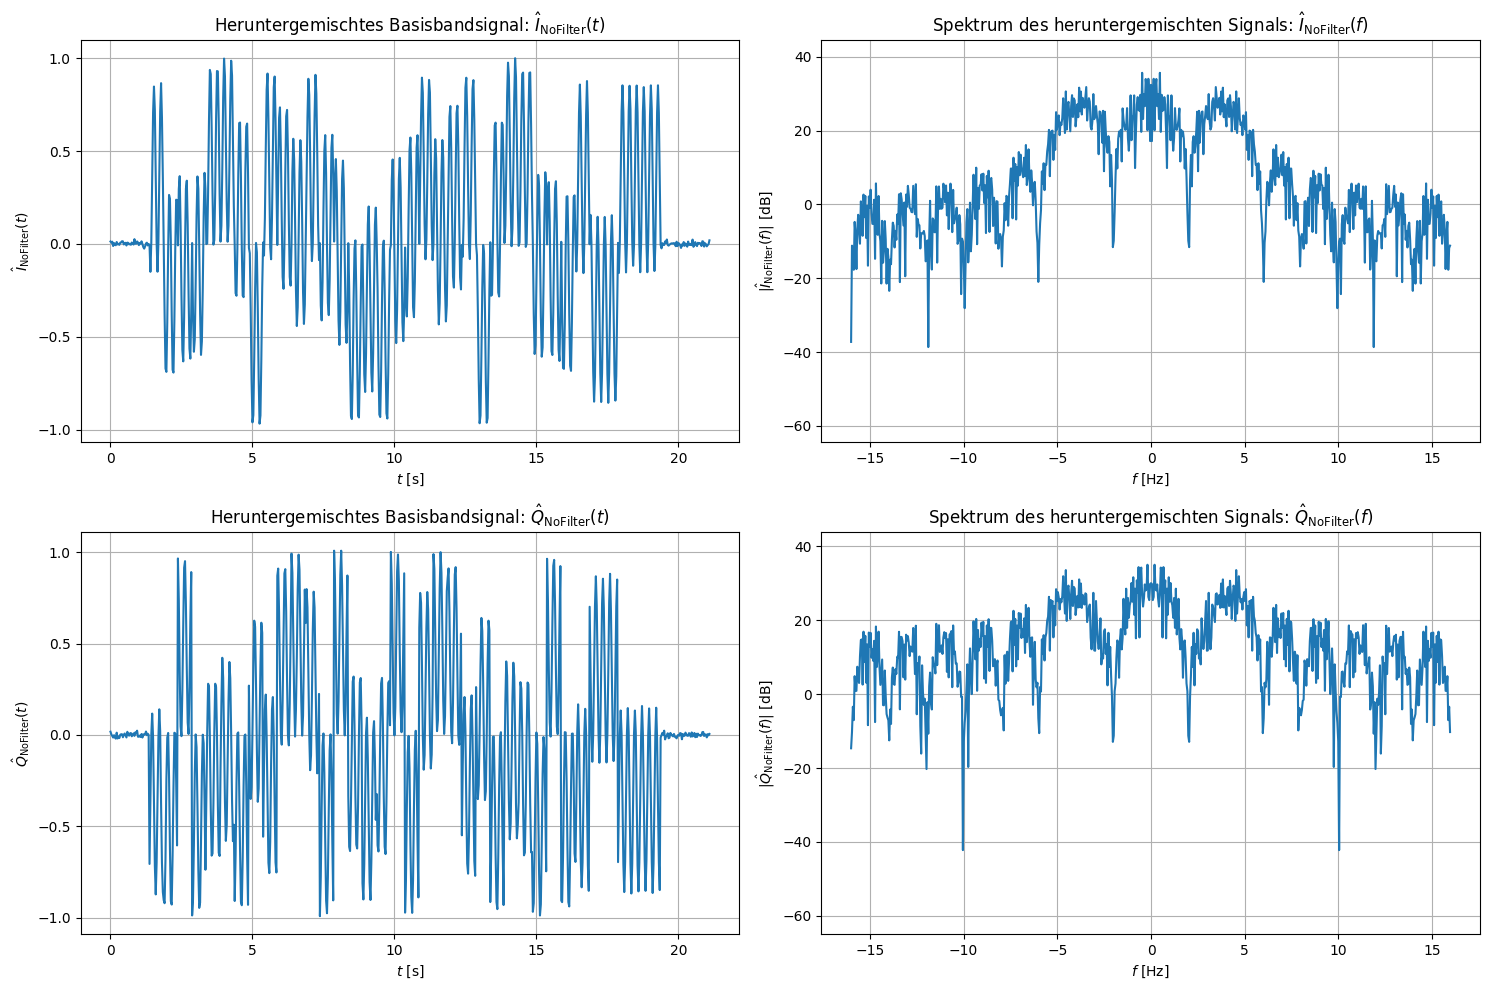

In [140]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot I_hat_i_no_filter in time domain
ax1.plot(t, hat_i_no_filter)
ax1.set_title(r"Heruntergemischtes Basisbandsignal: $\hat{I}_{\rm{No Filter}}(t)$")
ax1.set_xlabel(r"$t$ [s]")
ax1.set_ylabel(r"$\hat{I}_{\rm{No Filter}}(t)$")
ax1.grid(True)
ax1.set_yticks([-1, -0.5, 0, 0.5, 1])

# Plot I_hat_i_no_filter_spectrum in frequency domain
ax2.plot(f, 10 * np.log10(np.abs(hat_i_no_filter_spectrum) ** 2))
ax2.set_title(r"Spektrum des heruntergemischten Signals: $\hat{I}_{\rm{No Filter}}(f)$")
ax2.grid(True)
ax2.set_xlabel(r"$f$ [Hz]")
ax2.set_ylabel(r"|$\hat{I}_{\rm{No Filter}}(f)$| [dB]")
max_val = np.max(10 * np.log10(np.abs(hat_i_no_filter_spectrum) ** 2))
ax2.set_ylim(max_val-100, 1.25*max_val)

# Plot Q_hat_q_no_filter in time domain
ax3.plot(t, hat_q_no_filter)
ax3.set_title(r"Heruntergemischtes Basisbandsignal: $\hat{Q}_{\rm{No Filter}}(t)$")
ax3.set_xlabel(r"$t$ [s]")
ax3.set_ylabel(r"$\hat{Q}_{\rm{No Filter}}(t)$")
ax3.grid(True)
ax3.set_yticks([-1, -0.5, 0, 0.5, 1])

# Plot Q_hat_q_no_filter_spectrum in frequency domain
ax4.plot(f, 10 * np.log10(np.abs(hat_q_no_filter_spectrum) ** 2))
ax4.set_title(r"Spektrum des heruntergemischten Signals: $\hat{Q}_{\rm{No Filter}}(f)$")
ax4.grid(True)
ax4.set_xlabel(r"$f$ [Hz]")
ax4.set_ylabel(r"|$\hat{Q}_{\rm{No Filter}}(f)$| [dB]")
max_val = np.max(10 * np.log10(np.abs(hat_q_no_filter_spectrum) ** 2))
ax4.set_ylim(max_val-100, 1.25*max_val)

plt.tight_layout()
plt.show()

### 2. Tiefpassfilterung zur Berechnung von $\hat{I}_{\text{Filtered}}(t)$

**Gegeben:**
- Frequenzarray `f` (enthält Frequenzwerte in Hz)
- Grafische Darstellung des Spektrums mit Frequenzachse in Hz

**Problemstellung:**
1. **Entfernung hochfrequenter Anteile** bei $-2f_c$ und $2f_c$
2. Bestimmung der **Abschneidefrequenz** $f_k$ (kritische Frequenz in Hz):
   - Direkt ablesbar aus der Spektrumsdarstellung
   - Alternativ rechnerisch bestimmbar
3. **Umsetzung in Python**:
   - Nullsetzen aller Array-Werte außerhalb des gewünschten Spektrums
   - Erfordert präzise Zuordnung von Frequenzwerten (Hz) zu Array-Indizes

#### Aufgabe: Frequenz-zu-Index-Mapping
Implementierung einer Funktion `convert_f_Hz_to_index`, die:
- Eingabe: Einzelwert `f_Hz` (Ziel-Frequenz in Hz)
- Eingabe: Frequenzarray `f` (NumPy-Array)
- Ausgabe: Index $k$ desjenigen Array-Elements, das **am nächsten** an `f_Hz` liegt


In [141]:
def convert_f_Hz_to_index(f_Hz: float, f: np.ndarray) -> int:
    """
    Findet den Index der Frequenz in einem Array `f`, die am nächsten zum Zielwert `f_Hz` liegt.

    Diese Funktion berechnet den elementweisen absoluten Unterschied zwischen dem Frequenzarray `f`
    und der Ziel-Frequenz `f_Hz` und gibt den Index des minimalen Unterschieds zurück.

    Parameter:
        f_Hz (float): Ziel-Frequenz in Hertz, für die der nächstgelegene Index gesucht wird.
        f (np.ndarray): 1D-Array von Frequenzwerten in Hertz, typischerweise aus einer FFT- oder
                        Frequenzanalyse generiert.

    Rückgabe:
        int: Index des Werts in `f`, der `f_Hz` am nächsten liegt. Bei mehreren gleichen Minima wird
             der erste auftretende Index zurückgegeben.

    Beispiele:
        >>> f = np.array([0, 100, 200, 300, 400])  # Frequenzarray in Hz
        >>> convert_f_Hz_to_index(250, f)
        2  # da 200 näher an 250 liegt als 300
        >>> convert_f_Hz_to_index(300, f)
        3  # exakte Übereinstimmung

    Anwendungskontext:
        - Nützlich zur Identifikation von Frequenzbändern in Fourier-Transformationen (FFT)
        - Mapping von physikalischen Frequenzen auf diskrete Frequenz-Indizes in Spektralanalysen
    """
    return np.argmin(np.abs(f - f_Hz))


### Design eines Filters

Ziel: Das Spektrum des heruntergemischten Signals $\mathfrak{F}\{\hat{I}_{\text{NoFilter}}(t)\}$ & $\mathfrak{F}\{\hat{Q}_{\text{NoFilter}}(t)\}$  soll durch Entfernen der Störungen bei $\pm 2f_c$ so bereinigt werden, dass im Idealfall die Hauptkomponenten des ursprüngliche Sendesignal-Spektrum $\mathfrak{F}\{x_{\text{I, shaped}}(t)\}$ & $\mathfrak{F}\{x_{\text{Q, shaped}}(t)\}$ (vor der Hochmischung) übrig bleiben.

$$
    \hat{I}_{\text{NoFilter}}(t) = \frac{1}{2} I(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t) I(t) \sin(4\pi f_{\text{c}} t) + \frac{1}{2} I(t)
$$
$$
    \hat{Q}_{\text{NoFilter}}(t) = \frac{1}{2} I(t) Q(t) \sin(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t)
$$

#### Aufgabe:
- Designen Sie ein solches Filter $H_{\tiny{\text{TP}}}(f)$ in `H_tp`, welches das Ziel erreichen kann (Hinweis: Ein Rechteck Signal $\text{rect}(f)$ könnte ein solches Verhalten erzielen)
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`
- Verwenden Sie dabei die oben implementierte Funktion `convert_f_Hz_to_index`, welche `f_Hz` auf dessen Frequenzindex $k$ abbildet.
- Vergessen Sie nicht mit dem Filter gleichzeitig den Faktor $\frac{1}{2}$ im letzten Summanden aus $\hat{I}_{\text{NoFilter}}(t)$ `I_hat_i_no_filter` zu korrigieren.

In [142]:
f = np.fft.fftshift(np.fft.fftfreq(len(hat_i_no_filter), T_sample))

H_tp = np.zeros(len(f))
# correct the 1/2 factor from downconversion

# TODO: Calculate the Nyquist frequency and set the cutoff frequency to 1/4 of the Nyquist frequency
border = 1/T_s
# index from f at border
left_index = convert_f_Hz_to_index(-border, f)
rigth_index = convert_f_Hz_to_index(border, f) + 1
H_tp[left_index:rigth_index] = 1
H_tp = H_tp * 2

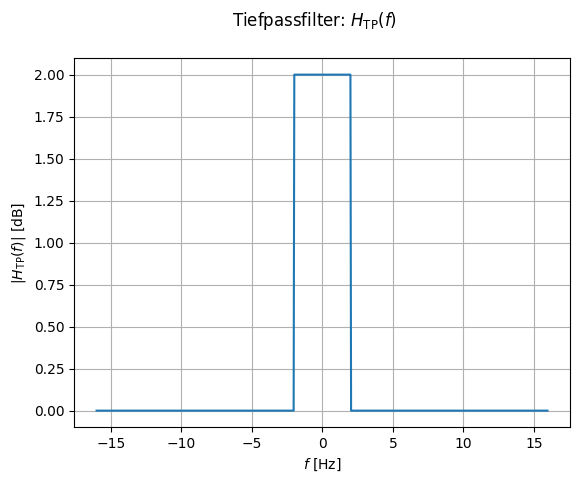

In [143]:
plt.suptitle(r"Tiefpassfilter: $H_{\rm{TP}}(f)$")
plt.plot(f, H_tp)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$|H_{\rm{TP}}(f)|$ [dB]")
plt.grid(True)

#### Aufgabe:
- Wenden Sie $H_{\tiny{\text{TP}}}(f)$ auf $\hat{I}_{\text{NoFilter}}(f)$ und legen Sie das Ergebnis in `hat_i_filtered_spectrum` ab:
$$
    \hat{I}_{\text{Filtered}}(f) = \hat{I}_{\text{NoFilter}}(f) \cdot H_{\tiny{\text{TP}}}(f)
$$
- Wenden Sie $H_{\tiny{\text{TP}}}(f)$ auf $\hat{Q}_{\text{NoFilter}}(f)$ und legen Sie das Ergebnis in `hat_q_filtered_spectrum` ab:
$$
    \hat{Q}_{\text{Filtered}}(f) = \hat{Q}_{\text{NoFilter}}(f) \cdot H_{\tiny{\text{TP}}}(f)
$$
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`


In [144]:
hat_i_filtered_spectrum = hat_i_no_filter_spectrum * H_tp
hat_q_filtered_spectrum = hat_q_no_filter_spectrum * H_tp
f = np.fft.fftshift(np.fft.fftfreq(hat_i_filtered_spectrum.size, T_sample))

/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/174643555.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(f, 10 * np.log10(np.abs(hat_i_filtered_spectrum) ** 2))
/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/174643555.py:9: RuntimeWarning: divide by zero encountered in log10
  max_val = np.max(10 * np.log10(np.abs(hat_i_filtered_spectrum) ** 2))
/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/174643555.py:13: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f, 10 * np.log10(np.abs(hat_q_filtered_spectrum) ** 2))
/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/174643555.py:18: RuntimeWarning: divide by zero encountered in log10
  max_val = np.max(10 * np.log10(np.abs(hat_q_filtered_spectrum) ** 2))


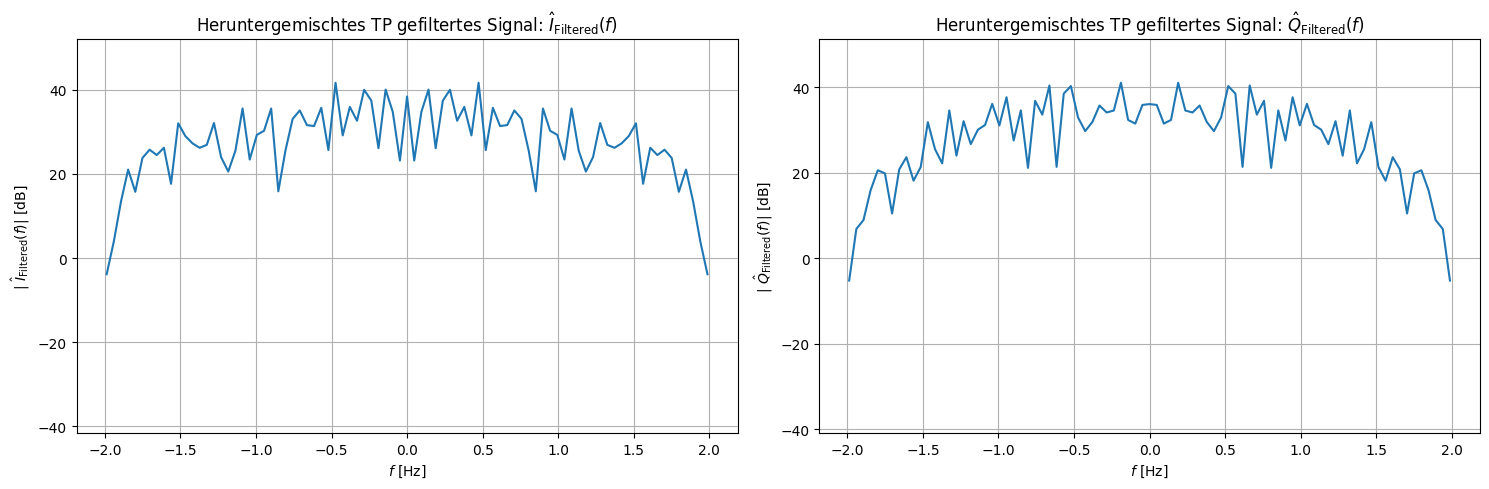

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot I_hat_i_filtered_spectrum
ax1.plot(f, 10 * np.log10(np.abs(hat_i_filtered_spectrum) ** 2))
ax1.set_title(r"Heruntergemischtes TP gefiltertes Signal: $\hat{I}_{\rm{Filtered}}(f)$")
ax1.set_xlabel(r"$f$ [Hz]")
ax1.set_ylabel(r"| $\hat{I}_{\rm{Filtered}}(f) | $ [dB]")
ax1.grid(True)
max_val = np.max(10 * np.log10(np.abs(hat_i_filtered_spectrum) ** 2))
ax1.set_ylim(-max_val, 1.25*max_val)

# Plot Q_hat_q_filtered_spectrum
ax2.plot(f, 10 * np.log10(np.abs(hat_q_filtered_spectrum) ** 2))
ax2.set_title(r"Heruntergemischtes TP gefiltertes Signal: $\hat{Q}_{\rm{Filtered}}(f)$")
ax2.set_xlabel(r"$f$ [Hz]")
ax2.set_ylabel(r"| $\hat{Q}_{\rm{Filtered}}(f) | $ [dB]")
ax2.grid(True)
max_val = np.max(10 * np.log10(np.abs(hat_q_filtered_spectrum) ** 2))
ax2.set_ylim(-max_val, 1.25*max_val)

plt.tight_layout()
plt.show()

#### Aufgabe:
- Transformieren Sie nun $\hat{I}_{\text{Filtered}}(f)$ wieder in den Zeitbereich in `hat_i_filtered`
- Transformieren Sie nun $\hat{Q}_{\text{Filtered}}(f)$ wieder in den Zeitbereich in `hat_q_filtered`
- Erstellen Sie dazu einen passenden Zeitvektor `t`

In [146]:
hat_i_filtered = np.fft.ifft(np.fft.fftshift(hat_i_filtered_spectrum)).real
hat_q_filtered = np.fft.ifft(np.fft.fftshift(hat_q_filtered_spectrum)).real

t = np.arange(hat_i_filtered.size) * T_sample

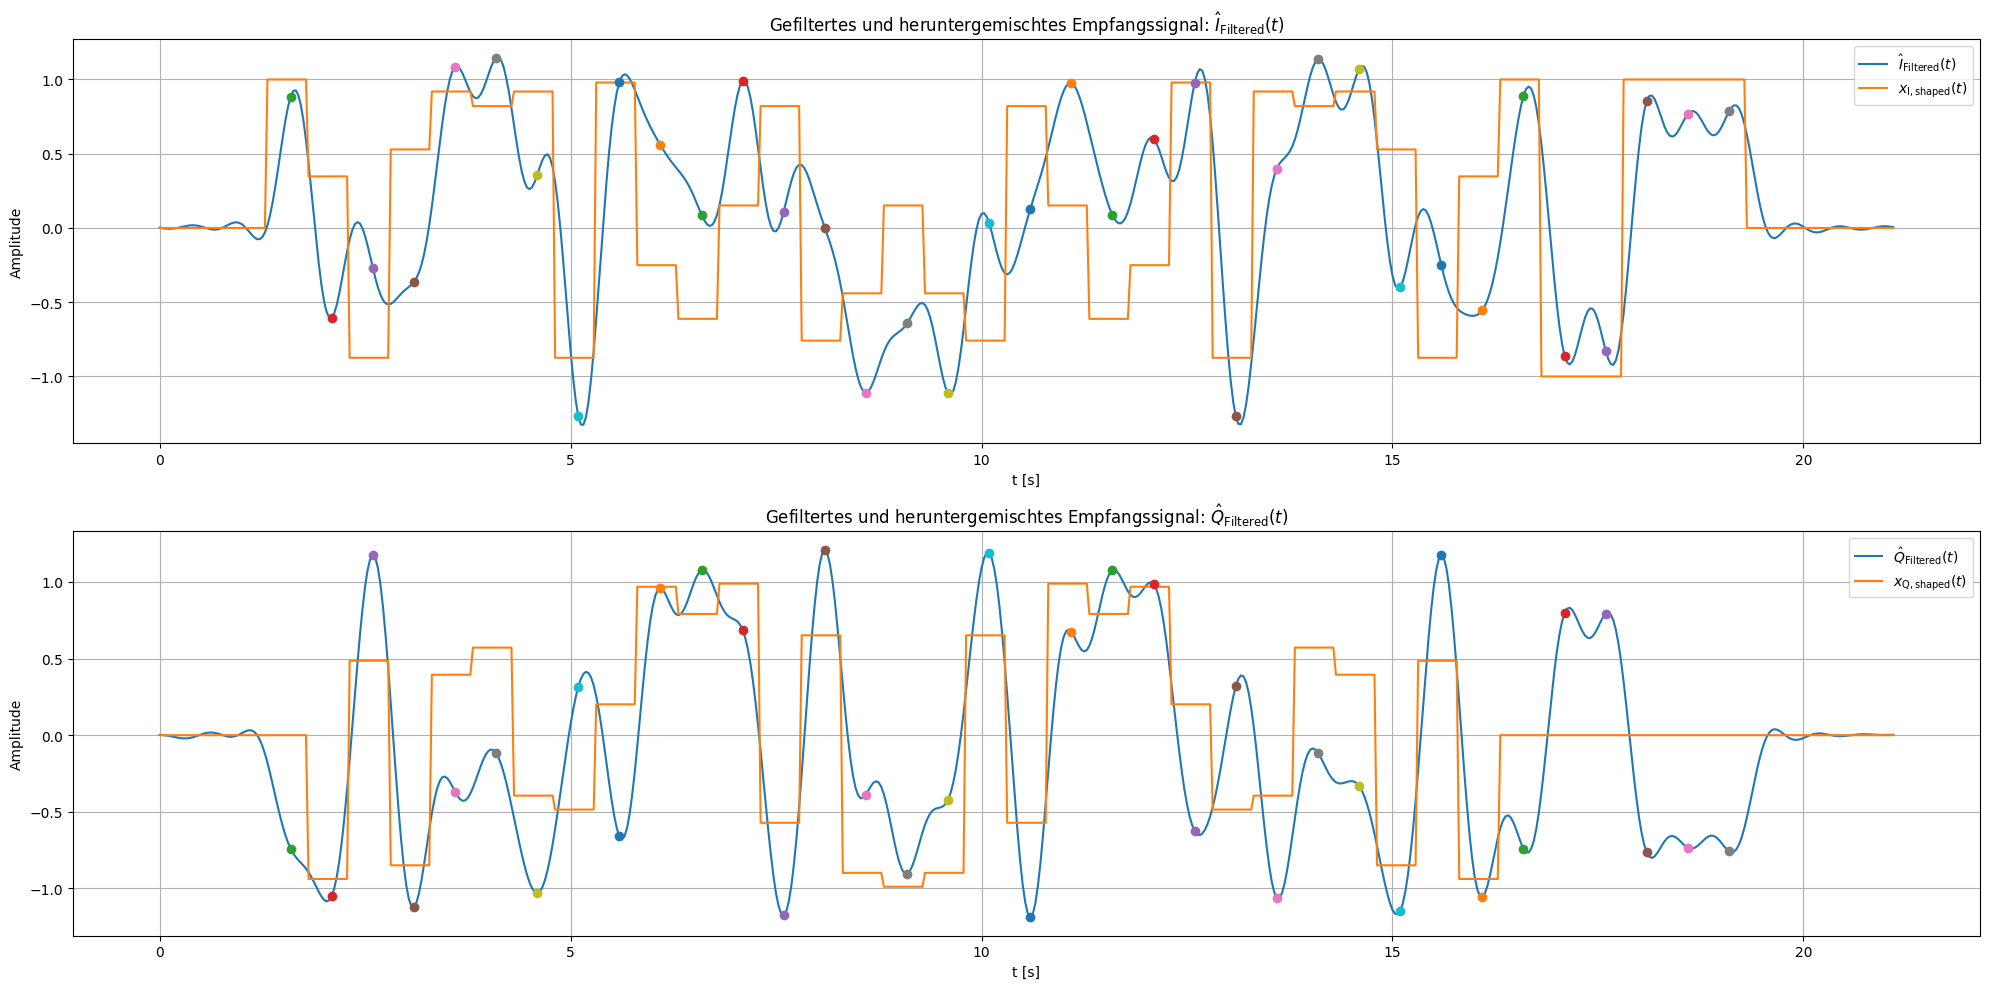

In [147]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot for I_hat_i_filtered and x_i_shaped
ax1.plot(t, hat_i_filtered.real)
ax1.plot(t, x_i_shaped)
ax1.grid(True)
ax1.legend([r'$\hat{I}_{\rm{Filtered}}(t)$', r'$x_{\rm{I,shaped}}(t)$'])

# Berechnung der Abtastzeitpunkte
sample_times = (np.arange(len(hat_i_filtered)) + (num_taps // 2)) * T_sample

start = num_taps // 2 + 1
end = hat_i_filtered.size - num_taps // 2
sample_times = np.arange(symbols.size)
n = start

while n <= end:
    ax1.plot(t[n], hat_i_filtered[n], 'o')
    n += sps

ax1.set_xlabel(r't [s]')
ax1.set_ylabel('Amplitude')
ax1.set_title(r'Gefiltertes und heruntergemischtes Empfangssignal: $\hat{I}_{\rm{Filtered}}(t)$')

# Plot for Q_hat_q_filtered and x_q_shaped
ax2.plot(t, hat_q_filtered.real)
ax2.plot(t, x_q_shaped)
ax2.grid(True)
ax2.legend([r'$\hat{Q}_{\rm{Filtered}}(t)$', r'$x_{\rm{Q,shaped}}(t)$'])

# Berechnung der Abtastzeitpunkte
sample_times = (np.arange(len(hat_q_filtered)) + (num_taps // 2)) * T_sample

start = num_taps // 2 + 1
end = hat_q_filtered.size - num_taps // 2
sample_times = np.arange(symbols.size)
n = start

while n <= end:
    ax2.plot(t[n], hat_q_filtered[n], 'o')
    n += sps

ax2.set_xlabel(r't [s]')
ax2.set_ylabel('Amplitude')
ax2.set_title(r'Gefiltertes und heruntergemischtes Empfangssignal: $\hat{Q}_{\rm{Filtered}}(t)$')

plt.tight_layout()
plt.show()

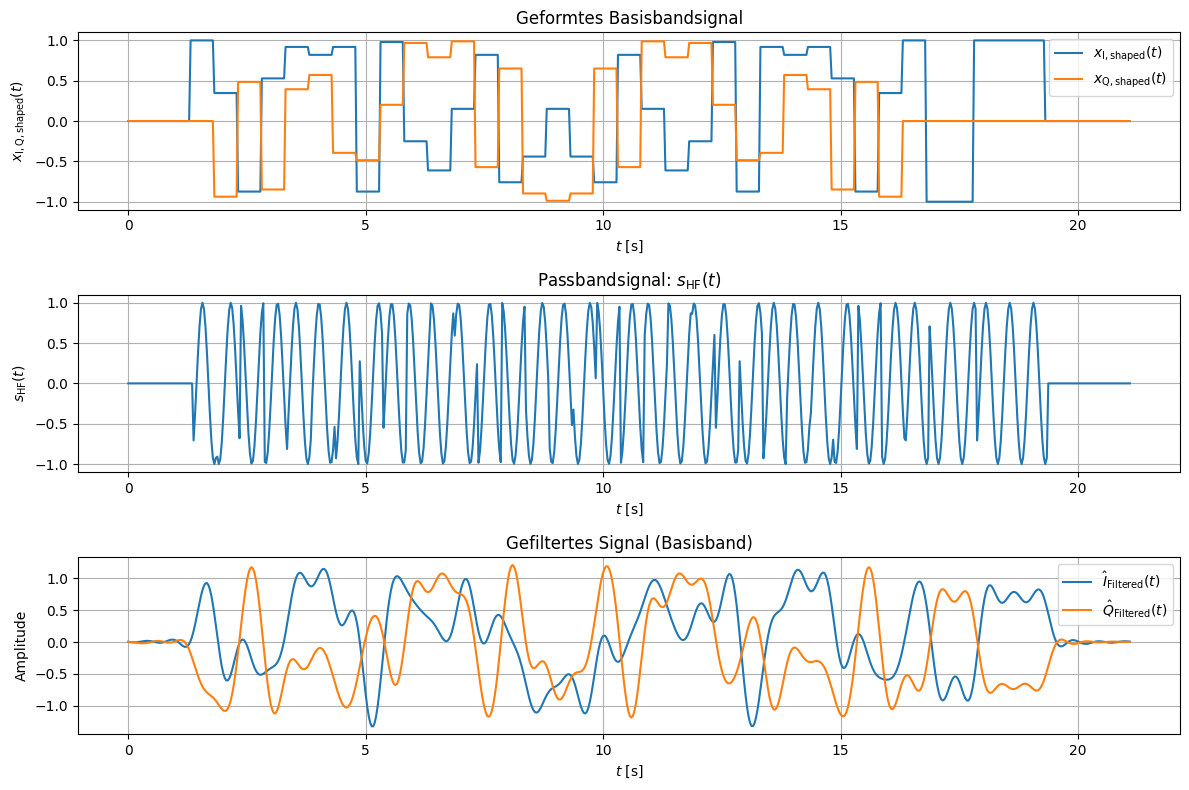

In [148]:
# TODO: Konsistente Farben dafür verwenden 1 Farbe für alles was das SDR macht und eine Farbe die man selbst der API übergibt

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, x_i_shaped)
plt.plot(t, x_q_shaped)
plt.title(r"Geformtes Basisbandsignal")
plt.xlabel(r'$t$ [s]')
plt.ylabel(r"$x_{\rm{I,Q, shaped}}(t)$")
plt.legend([r"$x_{\rm{I, shaped}}(t)$", r"$x_{\rm{Q, shaped}}(t)$"])
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, s_hf)
plt.title(r"Passbandsignal: $s_{\rm{HF}}(t)$")
plt.xlabel(r'$t$ [s]')
plt.ylabel(r"$s_{\rm{HF}}(t)$")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, hat_i_filtered)
plt.plot(t, hat_q_filtered)
plt.title(r"Gefiltertes Signal (Basisband)")
plt.xlabel(r'$t$ [s]')
plt.ylabel(r"Amplitude")
plt.legend([r"$\hat{I}_{\rm{Filtered}}(t)$", r"$\hat{Q}_{\rm{Filtered}}(t)$"])
plt.grid(True)

plt.tight_layout()
plt.show()

# Frage: Woher kommen wenn ein Rechteck als Basisbandpulsform verwendet wird unten nach der Tiefpassfilterung die Überschwinger?
- Ein Rechteck hat eine unendliche Bandbreite
- Bei der Tiefpassfilterung werden die hohen Frequenzen abgeschnitten
- Die Überschwinger kommen also daher, dass die hohen Frequenzen abgeschnitten werden und somit im Zeitbereich Überschwinger entstehen

/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/3283591285.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, np.fft.fftshift(10*np.log10(np.abs(np.fft.fft(hat_i_filtered_normalized)) ** 2)), color='black', linewidth=3, alpha=0.75)
/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/3283591285.py:17: RuntimeWarning: divide by zero encountered in log10
  max_value = np.max(10*np.log10(np.abs(np.fft.fft(hat_i_filtered_normalized))**2))


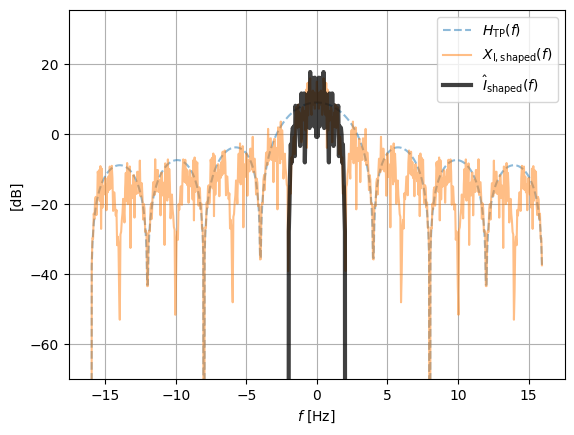

In [149]:
f = np.fft.fftshift(np.fft.fftfreq(hat_i_filtered.size, T_sample))

# Hier anpassen, je nachdem welcher Basisbandpuls verwendet wurde (Rechteck oder Raised Cosine)
base_band_pulse = get_rect_pulse(num_taps=len(hat_i_filtered))

hat_i_filtered_normalized   = normalize_energy(hat_i_filtered)
x_i_shaped_normalized       = normalize_energy(x_i_shaped)
baseband_signal_normalized  = normalize_energy(base_band_pulse)

plt.plot(f, np.fft.fftshift(10*np.log10(np.abs(np.fft.fft(baseband_signal_normalized))**2)),  alpha=0.5, linestyle='--')
plt.plot(f, np.fft.fftshift(10*np.log10(np.abs(np.fft.fft(x_i_shaped_normalized     ))** 2)),  alpha=0.5, linestyle='-')
plt.plot(f, np.fft.fftshift(10*np.log10(np.abs(np.fft.fft(hat_i_filtered_normalized)) ** 2)), color='black', linewidth=3, alpha=0.75)

plt.legend([r"$H_{\rm{TP}}(f)$", r"$X_{\rm{I,shaped}}(f)$", r"$\hat{I}_{\rm{shaped}}(f)$"])
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("[dB]")
max_value = np.max(10*np.log10(np.abs(np.fft.fft(hat_i_filtered_normalized))**2))
plt.ylim(-70, 2*max_value)
plt.grid(True)


## 3. ADC von $\hat{I}_{\tiny{\text{Filtered}}}(t)$ & $\hat{Q}_{\tiny{\text{Filtered}}}(t)$

#### Aufgabe:
- Führen sie das Sampling für $\hat{I}_{\tiny{\text{Filtered}}}(t)$, welches in `I_hat_i_filtered` gespeichert ist aus (Hinweis: $f_s = \text{sps}$)
- Aufgrund des Filterns wurde $\hat{I}_{\tiny{\text{Filtered}}}(t)$ komplex
- Speichern Sie den Realteil der Samples in `real_part`
- $\hat{Q}_{\tiny{\text{Filtered}}}(t) = 0$, da BPSK verwendet wurde. Der Vollständigkeit halber wird es hier dennoch berücksichtigt.
- Führen Sie `real_part` und `imag_part` in ein NumPy Array `sdr_iq_samples` vom Typ `np.complex64` zusammen, wobei: `sdr_iq_samples`$[i] =$ `real_part`$[i]$ + $j$ ` imag_part`$[i]$
- Dies ist das Ergebnis, welches Ihnen die uhd Bibliothek nach einer Messung bereitstellt

In [150]:
fs = sps

# Das ist nun der I Teil des empfangenen Signals
real_part = hat_i_filtered[::fs].real
imag_part = hat_q_filtered[::fs].real

# Das SDR liefert nun daraus ein NumpPy Array mit dem dtype complex64
sdr_iq_samples = (real_part + 1j * imag_part).astype(np.complex64)


In [151]:
print(sdr_iq_samples)

[ 0.00238477+0.00216458j  0.01036125+0.00387831j  0.02526101+0.01306736j
  0.61766833-0.5976702j  -0.489686  -1.0739052j  -0.05394505+0.9687769j
 -0.41151923-0.9747167j   0.92145157-0.28030547j  1.0325131 -0.10355368j
  0.26107046-0.95889485j -0.8253121 +0.06968522j  0.67585164-0.4239378j
  0.65005183+0.841979j    0.21347108+0.99180293j  0.8088786 +0.75274473j
 -0.02289597-1.0316305j   0.15785871+0.9994526j  -1.0173808 -0.39268562j
 -0.6988735 -0.8291621j  -0.93110794-0.47116584j  0.09459549+1.0900298j
 -0.05566773-0.96917015j  0.9232419 +0.64203215j  0.23284903+0.9718055j
  0.5648315 +0.9752207j   0.67273957-0.45022634j -0.84234107+0.07040406j
  0.19232853-0.8528623j   1.0255662 -0.09530419j  0.91682965-0.29947543j
 -0.32002228-1.138658j   -0.02668507+0.956902j   -0.59070104-0.9217849j
  0.62454635-0.607408j   -0.5162428 +0.5449133j  -0.6225669 +0.70302874j
  0.54294175-0.535913j    0.6762088 -0.69039804j  0.6759864 -0.70042145j
  0.08317853-0.087433j    0.00815006-0.01849817j  0.0086

In [152]:
sdr_iq_samples


array([ 0.00238477+0.00216458j,  0.01036125+0.00387831j,
        0.02526101+0.01306736j,  0.61766833-0.5976702j ,
       -0.489686  -1.0739052j , -0.05394505+0.9687769j ,
       -0.41151923-0.9747167j ,  0.92145157-0.28030547j,
        1.0325131 -0.10355368j,  0.26107046-0.95889485j,
       -0.8253121 +0.06968522j,  0.67585164-0.4239378j ,
        0.65005183+0.841979j  ,  0.21347108+0.99180293j,
        0.8088786 +0.75274473j, -0.02289597-1.0316305j ,
        0.15785871+0.9994526j , -1.0173808 -0.39268562j,
       -0.6988735 -0.8291621j , -0.93110794-0.47116584j,
        0.09459549+1.0900298j , -0.05566773-0.96917015j,
        0.9232419 +0.64203215j,  0.23284903+0.9718055j ,
        0.5648315 +0.9752207j ,  0.67273957-0.45022634j,
       -0.84234107+0.07040406j,  0.19232853-0.8528623j ,
        1.0255662 -0.09530419j,  0.91682965-0.29947543j,
       -0.32002228-1.138658j  , -0.02668507+0.956902j  ,
       -0.59070104-0.9217849j ,  0.62454635-0.607408j  ,
       -0.5162428 +0.5449133j ,

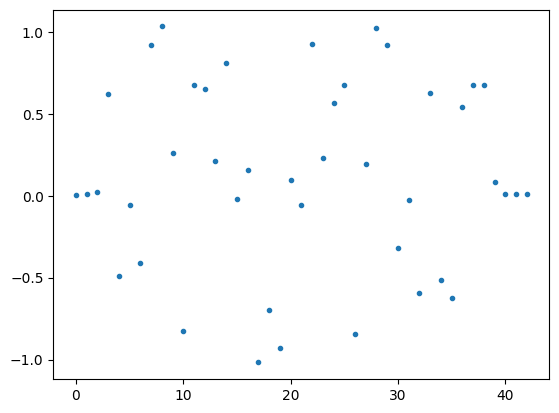

In [153]:
plt.plot(sdr_iq_samples, '.')

# Ende des Notebooks, Nachfolgender Teil kommt in die Synchronisation

# Am ende den SDR Teil überspringen
# SDR Box mit farben verwenden die wieder zeigt was das sdr macht und was das eigene Signal ist

# Nächstes Notebook: SIGMF Reader Vorbereiten, notebook vorbereiten, wie bursts übertragen werden
Ziel SiGMF FIles erzeugen, einlesen

1. Sigmf Schreiben (Burst Dauer, CFO, Fc etc einstellen)
2. Sigmf lesen und auf API Schnittstelle zum sendn bringen
3. Ziel für Praxisphase: man kann sigmf files breitstellen
4. Dann Synchronisation

/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_47474/4254250155.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[i] = np.dot(sdr_iq_samples[i:i+len(synchronization_sequence)], np.conjugate(synchronization_sequence))


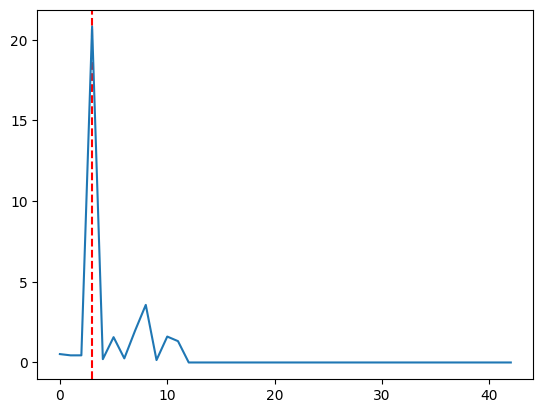

In [154]:
corr = np.zeros(len(sdr_iq_samples))

for i in range(len(sdr_iq_samples) - len(synchronization_sequence)):
    corr[i] = np.dot(sdr_iq_samples[i:i+len(synchronization_sequence)], np.conjugate(synchronization_sequence))

tau0 = np.argmax(np.abs(corr))
plt.axvline(tau0, color='r', linestyle='--')
plt.plot(np.abs(corr))

In [155]:
print(f"tau0: {tau0}")
print(f"rx len: {len(sdr_iq_samples)}")


tau0: 3
rx len: 43


In [156]:
# data bits start at tau0 + len(syncronisation_sequence) and end at tau0 + len(syncronisation_sequence) + len(data_bits)

data_symbols_received = sdr_iq_samples[tau0+len(synchronization_sequence):tau0 + len(synchronization_sequence) + len(data_bits)]

In [158]:
print(data_symbols_received)
# channel_estimation
pilot_symbol = -1 + 0j
index = 0

h = (data_symbols_received[index] * np.conjugate(pilot_symbol)) / (np.abs(pilot_symbol)**2)
#h = data_symbols_received[index] / pilot_symbol
data_symbols_received_eq = (data_symbols_received * np.conjugate(h)) / (np.abs(h)**2)
#data_symbols_received_eq = data_symbols_received / h
data_symbols_received_eq

[-0.5162428 +0.5449133j  -0.6225669 +0.70302874j  0.54294175-0.535913j
  0.6762088 -0.69039804j  0.6759864 -0.70042145j]


array([-1.       +2.3667763e-08j, -1.2503355+4.2042937e-02j,
        1.0157583+3.4067616e-02j,  1.2872688+2.1408163e-02j,
        1.2967589+1.2009247e-02j], dtype=complex64)

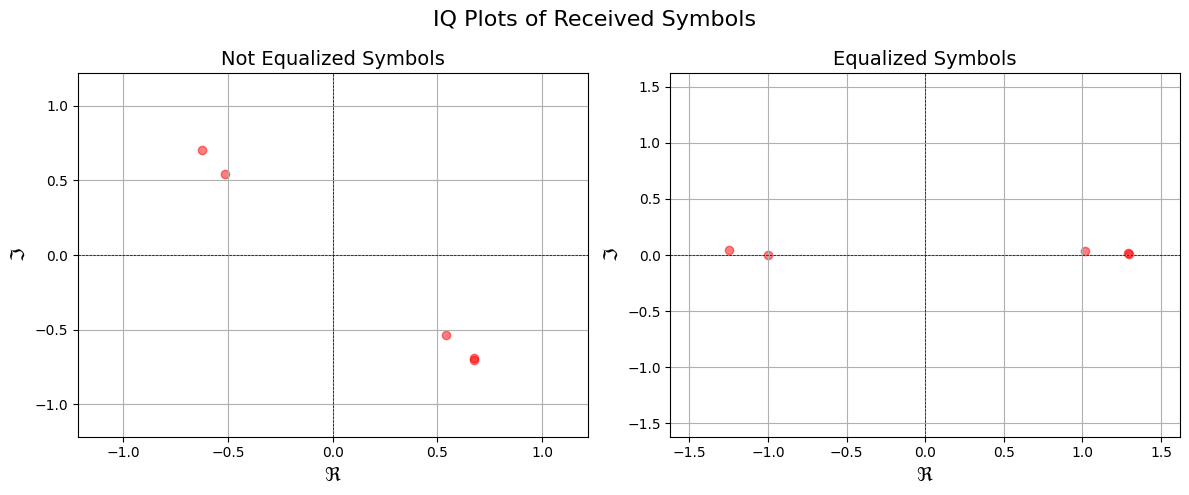

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('IQ Plots of Received Symbols', fontsize=16)

# Function to create a single IQ plot
def create_iq_plot(ax, data, title):
    max_val = np.max(np.abs(data))
    scale_factor = 1.25
    ax.scatter(np.real(data), np.imag(data), alpha=0.5, color='red')
    ax.set_ylim(-scale_factor*max_val, scale_factor*max_val)
    ax.set_xlim(-scale_factor*max_val, scale_factor*max_val)
    ax.grid(True)
    ax.set_xlabel(r'$\Re$', fontsize=14)
    ax.set_ylabel(r'$\Im$', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

# Create the first IQ plot (not equalized)
create_iq_plot(ax1, data_symbols_received, 'Not Equalized Symbols')

# Create the second IQ plot (equalized)
create_iq_plot(ax2, data_symbols_received_eq, 'Equalized Symbols')

plt.tight_layout()
plt.show()

In [160]:
data_symbols_received_eq

array([-1.       +2.3667763e-08j, -1.2503355+4.2042937e-02j,
        1.0157583+3.4067616e-02j,  1.2872688+2.1408163e-02j,
        1.2967589+1.2009247e-02j], dtype=complex64)

In [161]:
# decision making
data_bits_received = np.zeros_like(data_bits)
for i, symbol in enumerate(data_symbols_received_eq):
    if symbol.real > 0:
        data_bits_received[i] = 1
    else:
        data_bits_received[i] = 0

print("bits^hat = ", data_bits_received)
print("bits     = ", data_bits)

bits^hat =  [0 0 1 1 1]
bits     =  [0 0 1 1 1]
